In [135]:
# Standard, ML, and Finance Imports
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader
from torch.cuda.amp import GradScaler, autocast

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import plotly.graph_objects as go
import yfinance as yf
import os
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error, r2_score
from sklearn.model_selection import TimeSeriesSplit, train_test_split
import optuna
from statsmodels.tsa.arima.model import ARIMA
from datetime import datetime
import joblib
import pickle

# Set up device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")
if torch.cuda.is_available():
    print(f"PyTorch version: {torch.__version__}")
    print(f"GPU: {torch.cuda.get_device_name(0)}")

Using device: cuda
PyTorch version: 2.5.1
GPU: NVIDIA GeForce RTX 4060 Laptop GPU


In [136]:
# Clear GPU cache
torch.cuda.empty_cache()
print("GPU cache cleared.")

# Check memory usage (optional)
print(f"Allocated memory: {torch.cuda.memory_allocated() / 1024**2:.2f} MB")
if hasattr(torch.cuda, 'memory_reserved'):
    print(f"Reserved memory: {torch.cuda.memory_reserved() / 1024**2:.2f} MB")
else: # Fallback for older PyTorch versions
    print(f"Cached memory: {torch.cuda.memory_cached() / 1024**2:.2f} MB")

GPU cache cleared.
Allocated memory: 24.97 MB
Reserved memory: 106.00 MB


### 1. Pipeline de Procesamiento de Datos y Feature Engineering

Este pipeline se encarga de todo el proceso de preparación de datos:
1.  **Ingesta de Datos**: Descarga los precios de cierre diarios del IPC (`^MXX`) y de un conjunto de acciones relevantes del mercado mexicano usando `yfinance`.
2.  **Filtrado por Correlación**: Elimina tickers que tienen una correlación muy alta (>0.9) entre sí para evitar la multicolinealidad, conservando siempre el ticker objetivo (`^MXX`).
3.  **Ingeniería de Características (Feature Engineering)**: Calcula indicadores técnicos comunes (SMA, EMA, RSI, Bandas de Bollinger) para el IPC. Estos indicadores le dan al modelo más contexto sobre la tendencia, momento y volatilidad del mercado.
4.  **Limpieza Final**: Elimina cualquier fila con valores `NaN` que se generan al calcular los indicadores técnicos (que requieren un período inicial de datos).
5.  **Creación de Secuencias**: Transforma el set de datos en secuencias de `WINDOW_SIZE` (90 días) para entrenar el modelo LSTM. Cada secuencia de 90 días de todas las características se usa para predecir el precio del IPC del día 91.
6.  **División de Datos Robusta**: Utiliza `TimeSeriesSplit` para dividir los datos en conjuntos de entrenamiento y prueba, asegurando que el modelo no vea datos futuros durante el entrenamiento. Luego, se extrae un conjunto de validación del final del conjunto de entrenamiento.

In [137]:
# --- Data Processing Pipeline (UPDATED with Feature Engineering and Econometric Plots) ---
import plotly.subplots as sp

# --- Function to add technical indicators ---
def add_technical_indicators(df, ticker, window_size=20):
    """Adds technical indicators to the dataframe for a specific ticker."""
    df[f'{ticker}_SMA'] = df[ticker].rolling(window=window_size).mean()
    df[f'{ticker}_EMA'] = df[ticker].ewm(span=window_size, adjust=False).mean()
    delta = df[ticker].diff(1)
    gain = (delta.where(delta > 0, 0)).rolling(window=window_size).mean()
    loss = (-delta.where(delta < 0, 0)).rolling(window=window_size).mean()
    rs = gain / loss
    df[f'{ticker}_RSI'] = 100 - (100 / (1 + rs))
    df[f'{ticker}_BB_MA'] = df[ticker].rolling(window=window_size).mean()
    df[f'{ticker}_BB_STD'] = df[ticker].rolling(window=window_size).std()
    df[f'{ticker}_BB_UPPER'] = df[f'{ticker}_BB_MA'] + (df[f'{ticker}_BB_STD'] * 2)
    df[f'{ticker}_BB_LOWER'] = df[f'{ticker}_BB_MA'] - (df[f'{ticker}_BB_STD'] * 2)
    # We keep BB_MA for plotting, and drop it later before creating sequences
    return df

# --- Configuration ---
TARGET_TICKER = '^MXX'
WINDOW_SIZE = 90
feature_tickers = [
    'AC.MX', 'ALFAA.MX', 'ALPEKA.MX', 'AMXB.MX', 'ASURB.MX', 'BIMBOA.MX',
    'BOLSAA.MX', 'CEMEXCPO.MX', 'CUERVO.MX', 'ELEKTRA.MX', 'FEMSAUBD.MX',
    'GAPB.MX', 'GCARSOA1.MX', 'GENTERA.MX', 'GMEXICOB.MX', 'GRUMAB.MX',
    'IENOVA.MX', 'KIMBERA.MX', 'KOFUBL.MX', 'LABB.MX', 'LIVEPOLC-1.MX',
    'MEGACPO.MX', 'ORBIA.MX', 'PE&OLES.MX', 'PINFRA.MX', 'TLEVISACPO.MX',
    'VESTA.MX', 'WALMEX.MX', 'GMXT.MX', 'BBAJIOO.MX', 'RA.MX', 'SANMEXB.MX'
]
start_date = "2020-01-01"
end_date = datetime.today().strftime('%Y-%m-%d')
print(f"Fetching data from {start_date} to {end_date}...")

# --- Data Ingestion and Cleaning ---
all_tickers = [TARGET_TICKER] + feature_tickers
data = yf.download(all_tickers, start=start_date, end=end_date, auto_adjust=True, progress=False)
close_prices = data['Close'].dropna(how='all', axis=1)

# --- Correlation Filtering ---
correlation_matrix = close_prices.corr()
columns_to_remove = set()
for i in range(len(correlation_matrix.columns)):
    for j in range(i):
        if abs(correlation_matrix.iloc[i, j]) > 0.9:
            col_to_remove = correlation_matrix.columns[i]
            if col_to_remove != TARGET_TICKER and col_to_remove not in columns_to_remove:
                columns_to_remove.add(col_to_remove)
print(f"Tickers removed due to high correlation: {columns_to_remove}")
data_filtered = close_prices.drop(columns=columns_to_remove, errors='ignore')

# --- Feature Engineering ---
features_df_with_plot_cols = add_technical_indicators(data_filtered.copy(), TARGET_TICKER)

# Drop temporary columns used for plotting
features_df = features_df_with_plot_cols.drop(columns=[f'{TARGET_TICKER}_BB_MA', f'{TARGET_TICKER}_BB_STD'])
print(f"Added technical indicators. New shape: {features_df.shape}")
features_df.dropna(how='any', axis=0, inplace=True)
print(f"Shape after dropping NaNs: {features_df.shape}")

# Re-align plotting df with the final features_df
plot_df = features_df_with_plot_cols.loc[features_df.index]

# --- Final Data Structuring ---
all_cols = [col for col in features_df.columns if col != TARGET_TICKER]
new_order = [TARGET_TICKER] + all_cols
features_df = features_df[new_order]
if features_df.index.tz is not None:
    features_df.index = features_df.index.tz_localize(None)

# --- Sequence Creation ---
def create_multivariate_sequences(data: np.ndarray, window_size: int):
    x, y = [], []
    for i in range(len(data) - window_size):
        x.append(data[i:(i + window_size), :])
        y.append(data[i + window_size, 0])
    return np.array(x), np.array(y)

feature_scaler = MinMaxScaler()
features_scaled = feature_scaler.fit_transform(features_df)
X, y = create_multivariate_sequences(features_scaled, WINDOW_SIZE)

# --- Data Splitting with TimeSeriesSplit ---
tscv = TimeSeriesSplit(n_splits=5)
for train_index, test_index in tscv.split(X):
    X_train_full, X_test = X[train_index], X[test_index]
    y_train_full, y_test = y[train_index], y[test_index]
    dates_train_full, dates_test = features_df.index[WINDOW_SIZE:][train_index], features_df.index[WINDOW_SIZE:][test_index]

X_train, X_val, y_train, y_val, dates_train, dates_val = train_test_split(
    X_train_full, y_train_full, dates_train_full, test_size=0.1, shuffle=False
)

# --- Econometric and Data Split Visualization ---
fig = sp.make_subplots(rows=4, cols=1, shared_xaxes=True, vertical_spacing=0.05, 
                       subplot_titles=('Visualización de la División de Datos', 'Medias Móviles y Precio de Cierre', 'Índice de Fuerza Relativa (RSI)', 'Bandas de Bollinger'))

# Plot 1: Data Split
fig.add_trace(go.Scatter(x=plot_df.index, y=plot_df[TARGET_TICKER], name='Datos Completos', line=dict(color='lightgray')), row=1, col=1)
fig.add_trace(go.Scatter(x=dates_train, y=plot_df.loc[dates_train, TARGET_TICKER], name='Entrenamiento', line=dict(color='#1f77b4')), row=1, col=1)
fig.add_trace(go.Scatter(x=dates_val, y=plot_df.loc[dates_val, TARGET_TICKER], name='Validación', line=dict(color='#ff7f0e')), row=1, col=1)
fig.add_trace(go.Scatter(x=dates_test, y=plot_df.loc[dates_test, TARGET_TICKER], name='Prueba', line=dict(color='#2ca02c')), row=1, col=1)

# Plot 2: Moving Averages
fig.add_trace(go.Scatter(x=plot_df.index, y=plot_df[TARGET_TICKER], name='Precio IPC', line=dict(color='black', width=1)), row=2, col=1)
fig.add_trace(go.Scatter(x=plot_df.index, y=plot_df[f'{TARGET_TICKER}_SMA'], name='SMA (20)', line=dict(color='blue', dash='dash')), row=2, col=1)
fig.add_trace(go.Scatter(x=plot_df.index, y=plot_df[f'{TARGET_TICKER}_EMA'], name='EMA (20)', line=dict(color='orange', dash='dash')), row=2, col=1)

# Plot 3: RSI
fig.add_trace(go.Scatter(x=plot_df.index, y=plot_df[f'{TARGET_TICKER}_RSI'], name='RSI', line=dict(color='purple')), row=3, col=1)
fig.add_hline(y=70, line_dash="dash", line_color="red", row=3, col=1)
fig.add_hline(y=30, line_dash="dash", line_color="green", row=3, col=1)

# Plot 4: Bollinger Bands
fig.add_trace(go.Scatter(x=plot_df.index, y=plot_df[f'{TARGET_TICKER}_BB_UPPER'], name='Banda Superior', line=dict(color='rgba(173, 216, 230, 0.5)')), row=4, col=1)
fig.add_trace(go.Scatter(x=plot_df.index, y=plot_df[f'{TARGET_TICKER}_BB_LOWER'], name='Banda Inferior', line=dict(color='rgba(173, 216, 230, 0.5)'), fill='tonexty', fillcolor='rgba(173, 216, 230, 0.2)'), row=4, col=1)
fig.add_trace(go.Scatter(x=plot_df.index, y=plot_df[TARGET_TICKER], name='Precio IPC', line=dict(color='black', width=1)), row=4, col=1)

fig.update_layout(height=1000, template='plotly_white', showlegend=True, legend_tracegroupgap=220)
fig.update_yaxes(title_text="Precio IPC", row=1, col=1)
fig.update_yaxes(title_text="Precio IPC", row=2, col=1)
fig.update_yaxes(title_text="RSI", row=3, col=1)
fig.update_yaxes(title_text="Precio IPC", row=4, col=1)
fig.update_xaxes(title_text="Fecha", row=4, col=1)
fig.show()

# --- Tensor Conversion and DataLoader Creation ---
X_train_t = torch.tensor(X_train, dtype=torch.float32)
y_train_t = torch.tensor(y_train, dtype=torch.float32)
X_val_t = torch.tensor(X_val, dtype=torch.float32)
y_val_t = torch.tensor(y_val, dtype=torch.float32)
X_test_t = torch.tensor(X_test, dtype=torch.float32)
y_test_t = torch.tensor(y_test, dtype=torch.float32)

NUM_FEATURES = X_train_t.shape[2]
print(f"\nTarget Ticker: {TARGET_TICKER}")
print(f"Number of features (including technical indicators): {NUM_FEATURES}")

dl_args = {'batch_size': 64, 'shuffle': True, 'num_workers': 2, 'pin_memory': True, 'persistent_workers': True} if device.type == 'cuda' else {'batch_size': 64, 'shuffle': True}
test_dl_args = {**dl_args, 'shuffle': False}

train_loader = DataLoader(TensorDataset(X_train_t, y_train_t), **dl_args)
val_loader = DataLoader(TensorDataset(X_val_t, y_val_t), **test_dl_args)
test_loader = DataLoader(TensorDataset(X_test_t, y_test_t), **test_dl_args)

Fetching data from 2020-01-01 to 2025-07-24...



2 Failed downloads:
['SANMEXB.MX']: YFPricesMissingError('possibly delisted; no price data found  (1d 2020-01-01 -> 2025-07-24)')
['IENOVA.MX']: YFTzMissingError('possibly delisted; no timezone found')


Tickers removed due to high correlation: {'LIVEPOLC-1.MX', 'GENTERA.MX', 'KOFUBL.MX', 'ASURB.MX', 'RA.MX', 'GMXT.MX', 'GAPB.MX', 'PINFRA.MX', 'VESTA.MX'}
Added technical indicators. New shape: (1399, 27)
Shape after dropping NaNs: (1380, 27)



Target Ticker: ^MXX
Number of features (including technical indicators): 27


### 2. Definición de Modelos

In [138]:
# --- Model Definitions ---
class SimpleLSTM(nn.Module):
    def __init__(self, input_size, hidden_size=50, dropout=0.2):
        super().__init__()
        self.lstm = nn.LSTM(input_size, hidden_size, batch_first=True)
        self.dropout = nn.Dropout(dropout)
        self.linear = nn.Linear(hidden_size, 1)
    def forward(self, x):
        lstm_out, _ = self.lstm(x)
        out = self.dropout(lstm_out[:, -1, :])
        return self.linear(out).squeeze(-1)

class StackedLSTM(nn.Module):
    def __init__(self, input_size, hidden_size=50, num_layers=2, dropout=0.2):
        super().__init__()
        # Dropout is only applied if num_layers > 1
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True, dropout=dropout if num_layers > 1 else 0)
        self.linear = nn.Linear(hidden_size, 1)
    def forward(self, x):
        lstm_out, _ = self.lstm(x)
        out = lstm_out[:, -1, :]
        return self.linear(out).squeeze(-1)

### 3. Búsqueda de Hiperparámetros y Entrenamiento Final

1.  **Optimización con Optuna**: Buscamos la mejor combinación de hiperparámetros (tamaño de capas ocultas, dropout, tasa de aprendizaje) para nuestras tres arquitecturas: `SimpleLSTM`, `StackedLSTM` (con una capa para esta búsqueda). Optuna ejecutará 50 pruebas para encontrar la configuración más prometedora.
2.  **Entrenamiento del Modelo Final**: Una vez identificados los mejores parámetros, entrenamos el modelo ganador con el conjunto de datos de entrenamiento y validación completos. Utilizamos *Early Stopping* para prevenir el sobreajuste, deteniendo el entrenamiento cuando el rendimiento en el conjunto de validación deja de mejorar.

In [139]:
# This dictionary will store the training history for the learning curve plot
training_histories = {}

def objective(trial: optuna.trial.Trial):
    model_type = trial.suggest_categorical("model_type", ["simple_lstm", "stacked_lstm"])
    hidden_size = trial.suggest_int("hidden_size", 32, 256, log=True)
    dropout = trial.suggest_float("dropout", 0.1, 0.5)
    lr = trial.suggest_float("lr", 1e-4, 1e-2, log=True)
    num_layers = 1 # Keep number of layers fixed to 1 for stacked/attention models in this search

    tscv = TimeSeriesSplit(n_splits=5)
    cv_scores = []
    
    for fold, (train_idx, val_idx) in enumerate(tscv.split(X_train)):
        X_train_fold, X_val_fold = X_train[train_idx], X_train[val_idx]
        y_train_fold, y_val_fold = y_train[train_idx], y_train[val_idx]
        X_train_fold_t = torch.tensor(X_train_fold, dtype=torch.float32).to(device)
        y_train_fold_t = torch.tensor(y_train_fold, dtype=torch.float32).to(device)
        X_val_fold_t = torch.tensor(X_val_fold, dtype=torch.float32).to(device)
        y_val_fold_t = torch.tensor(y_val_fold, dtype=torch.float32).to(device)

        if model_type == "simple_lstm":
            model = SimpleLSTM(NUM_FEATURES, hidden_size, dropout)
        else: # stacked_lstm
            model = StackedLSTM(NUM_FEATURES, hidden_size, num_layers, dropout)
            
        model.to(device)
        optimizer = optim.Adam(model.parameters(), lr=lr)
        
        for epoch in range(15):
            model.train()
            optimizer.zero_grad()
            y_pred = model(X_train_fold_t)
            loss = criterion(y_pred, y_train_fold_t)
            loss.backward()
            optimizer.step()
        
        model.eval()
        with torch.no_grad():
            val_preds = model(X_val_fold_t)
            fold_loss = criterion(val_preds, y_val_fold_t).item()
            cv_scores.append(fold_loss)

    return np.mean(cv_scores)

# --- Run Optuna Study ---
print("--- Starting Optuna Hyperparameter Search ---")
study = optuna.create_study(direction="minimize")
study.optimize(objective, n_trials=50, n_jobs=1) 
best_params = study.best_trial.params
print(f"\nBest trial params: {best_params}")

# --- Final Model Training ---
model_init_params = best_params.copy()
model_type = model_init_params.pop('model_type')
learning_rate = model_init_params.pop('lr')

if model_type == 'simple_lstm':
    final_model = SimpleLSTM(NUM_FEATURES, **model_init_params)
else: # stacked_lstm
    final_model = StackedLSTM(NUM_FEATURES, num_layers=1, **model_init_params)

final_model_name = model_type.replace('_', ' ').title()
print(f"Training final model of type: {final_model_name}")

final_model.to(device)
if device.type == 'cuda' and hasattr(torch, 'compile'):
    print("Compiling the model for maximum efficiency...")
    final_model = torch.compile(final_model)

optimizer = optim.Adam(final_model.parameters(), lr=learning_rate)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', patience=10, factor=0.5, verbose=False)
grad_scaler = GradScaler(enabled=(device.type == 'cuda'))

best_val_loss = float('inf')
epochs_no_improve = 0
patience = 20
best_model_state = None

train_losses, val_losses = [], []

print("\n--- Training Final Model with Early Stopping ---")
for epoch in range(200):
    final_model.train()
    epoch_train_loss = 0
    for X_b, y_b in train_loader:
        X_b, y_b = X_b.to(device, non_blocking=True), y_b.to(device, non_blocking=True)
        optimizer.zero_grad()
        with autocast(enabled=(device.type == 'cuda'), dtype=torch.float16):
            pred = final_model(X_b)
            loss = criterion(pred, y_b)
        grad_scaler.scale(loss).backward()
        grad_scaler.step(optimizer)
        grad_scaler.update()
        epoch_train_loss += loss.item()
    train_losses.append(epoch_train_loss / len(train_loader))
    
    final_model.eval()
    val_loss = 0
    with torch.no_grad():
        for X_b, y_b in val_loader:
            X_b, y_b = X_b.to(device), y_b.to(device)
            with autocast(enabled=(device.type == 'cuda'), dtype=torch.float16):
                pred = final_model(X_b)
                val_loss += criterion(pred, y_b).item()
    val_loss /= len(val_loader)
    val_losses.append(val_loss)
    scheduler.step(val_loss)

    if (epoch + 1) % 10 == 0:
        print(f"Epoch [{epoch+1}/200], Train Loss: {train_losses[-1]:.6f}, Val Loss: {val_loss:.6f}")

    if val_loss < best_val_loss:
        best_val_loss = val_loss
        epochs_no_improve = 0
        best_model_state = final_model.state_dict()
    else:
        epochs_no_improve += 1

    if epochs_no_improve >= patience:
        print(f"Early stopping triggered after {epoch + 1} epochs.")
        break

if best_model_state:
    final_model.load_state_dict(best_model_state)

training_histories[final_model_name] = {'train_loss': train_losses, 'val_loss': val_losses}

--- Starting Optuna Hyperparameter Search ---



Best trial params: {'model_type': 'stacked_lstm', 'hidden_size': 211, 'dropout': 0.4866513517644423, 'lr': 0.0026890478998438027}
Training final model of type: Stacked Lstm
Compiling the model for maximum efficiency...

--- Training Final Model with Early Stopping ---
Epoch [10/200], Train Loss: 0.000914, Val Loss: 0.000843
Epoch [20/200], Train Loss: 0.000523, Val Loss: 0.001098
Epoch [30/200], Train Loss: 0.000469, Val Loss: 0.000915
Early stopping triggered after 38 epochs.


Nota Importante: Los resultados numéricos (métricas, ganancias, predicciones) que se muestran a continuación son el producto de una única ejecución del notebook. Debido a la naturaleza estocástica del entrenamiento de redes neuronales (inicialización de pesos, división de datos), los valores exactos variarán en cada ejecución. El objetivo de esta sección es demostrar la metodología de evaluación y la capacidad de interpretación de los resultados, más que presentar cifras estáticas.

Para evaluar el modelo de manera justa, se utilizó un conjunto de prueba que contiene datos que el modelo LSTM nunca vio durante su entrenamiento u optimización. La tabla y gráfica siguientes resumen el rendimiento de diferentes estrategias durante este período de prueba.


In [140]:
# --- Backtesting, Results Table, and Equity Curve ---
actual_prices = y_test_inv

# --- Backtesting Function ---
def backtest_strategy(predictions, actuals, initial_capital=10000, threshold=0.0025):
    capital_crossover, capital_threshold = initial_capital, initial_capital
    portfolio_crossover, portfolio_threshold = [initial_capital], [initial_capital]
    
    for i in range(1, len(actuals)):
        price_today = actuals[i-1]
        predicted_price_tomorrow = predictions[i]
        price_tomorrow = actuals[i]
        
        # Crossover Strategy
        if predicted_price_tomorrow > price_today:
            capital_crossover *= (price_tomorrow / price_today)
        
        # Threshold Strategy
        if predicted_price_tomorrow > price_today * (1 + threshold):
            capital_threshold *= (price_tomorrow / price_today)

        portfolio_crossover.append(capital_crossover)
        portfolio_threshold.append(capital_threshold)
    return portfolio_crossover, portfolio_threshold

# --- Predictions and Inverse Transform ---
def get_dl_predictions(model, loader):
    model.eval()
    preds = []
    with torch.no_grad():
        for X_b, _ in loader:
            X_b = X_b.to(device)
            with autocast(enabled=(device.type == 'cuda'), dtype=torch.float16):
                preds.extend(model(X_b).cpu().numpy())
    return np.array(preds)

def inverse_transform_preds(scaled_preds, scaler_obj, num_features):
    dummy = np.zeros((len(scaled_preds), num_features))
    dummy[:, 0] = scaled_preds.ravel()
    return scaler_obj.inverse_transform(dummy)[:, 0]

# Use the single test set defined earlier for a final out-of-sample check
y_test_pred_scaled = get_dl_predictions(final_model, test_loader)
y_test_inv = inverse_transform_preds(y_test_t.cpu().numpy(), feature_scaler, NUM_FEATURES)
lstm_final_preds = inverse_transform_preds(y_test_pred_scaled, feature_scaler, NUM_FEATURES)

# --- ARIMA Model Training (on the same final training data) ---
print("\n--- Entrenando y Prediciendo con Modelo ARIMA (Rolling Forecast) ---")
train_val_data = np.concatenate((y_train, y_val))
history = [x for x in inverse_transform_preds(train_val_data, feature_scaler, NUM_FEATURES)]
arima_preds = []
for t in range(len(y_test_inv)):
    try:
        model = ARIMA(history, order=(5,1,0))
        model_fit = model.fit()
        output = model_fit.forecast()
        yhat = output[0]
        arima_preds.append(yhat)
        obs = y_test_inv[t]
        history.append(obs)
    except Exception as e:
        # Fallback for convergence issues
        last_pred = arima_preds[-1] if arima_preds else history[-1]
        arima_preds.append(last_pred)
        history.append(y_test_inv[t])
print("Pronóstico dinámico de ARIMA finalizado.")

# --- Run Backtests and Calculate Metrics ---
all_predictions = { final_model_name: lstm_final_preds, "ARIMA": arima_preds }
results = []
backtest_histories = {}
initial_capital = 10000

for model_name, preds in all_predictions.items():
    cross_hist, thresh_hist = backtest_strategy(preds, y_test_inv, initial_capital=initial_capital)
    backtest_histories[f'{model_name} Crossover'] = cross_hist
    backtest_histories[f'{model_name} Threshold'] = thresh_hist
    
    rmse = np.sqrt(mean_squared_error(y_test_inv, preds))
    mape = mean_absolute_percentage_error(y_test_inv, preds)
    r2 = r2_score(y_test_inv, preds)
    
    results.append({
        "Model": model_name, "RMSE": rmse, "MAPE": mape, "R2 Score": r2,
        "Crossover Return": cross_hist[-1], "Threshold Return": thresh_hist[-1],
    })

# --- Buy & Hold Strategy ---
buy_hold_return = initial_capital * (y_test_inv / y_test_inv[0])
backtest_histories['Buy & Hold'] = buy_hold_return

# --- Final Results Table ---
results_df = pd.DataFrame(results).set_index("Model")
buy_hold_row = pd.DataFrame({
    "RMSE": [np.nan], "MAPE": [np.nan], "R2 Score": [np.nan],
    "Crossover Return": [buy_hold_return[-1]], "Threshold Return": [buy_hold_return[-1]]
}, index=["Buy & Hold"])

final_summary = pd.concat([buy_hold_row, results_df]).sort_values(by="Crossover Return", ascending=False)

# Add Gain Percentage column
final_summary['Gain %'] = (final_summary['Crossover Return'] / initial_capital) - 1

# Reorder columns to place Gain % next to returns
final_summary = final_summary[['RMSE', 'MAPE', 'R2 Score', 'Crossover Return', 'Threshold Return', 'Gain %']]

styled_summary = final_summary.style.format({
    "RMSE": "{:,.2f}", 
    "MAPE": "{:.2%}", 
    "R2 Score": "{:.3f}",
    "Crossover Return": "${:,.2f}", 
    "Threshold Return": "${:,.2f}",
    "Gain %": "{:+.2%}"  # Format with sign and percentage
}).background_gradient(
    cmap='Greens', subset=['Crossover Return', 'Threshold Return', 'R2 Score', 'Gain %']
).background_gradient(
    cmap='Reds_r', subset=['RMSE', 'MAPE']
).set_caption("Resumen Comparativo del Rendimiento de los Modelos")

print("\n--- Tabla de Resultados Finales ---")
display(styled_summary)

# --- Equity Curve Visualization ---
equity_curve_df = pd.DataFrame(backtest_histories, index=dates_test)
fig_equity = go.Figure()

colors = {'Simple Lstm': '#1f77b4', 'Stacked Lstm': '#1f77b4', 'Attention Lstm': '#9467bd', 'ARIMA': '#ff7f0e', 'Buy & Hold': 'gray'}

for col in equity_curve_df.columns:
    base_model_name = ' '.join(col.split(' ')[:-1])
    color = colors.get(base_model_name, 'gray')
    dash = 'dash' if 'Threshold' in col else 'solid'
    fig_equity.add_trace(go.Scatter(
        x=equity_curve_df.index, y=equity_curve_df[col],
        name=col, line=dict(color=color, dash=dash, width=2)
    ))

fig_equity.update_layout(
    title='Curva de Capital - Rendimiento de Estrategias de Inversión',
    xaxis_title='Fecha',
    yaxis_title='Valor del Portafolio ($)',
    yaxis_tickprefix='$', yaxis_tickformat=',.0f',
    template='plotly_white',
    legend_title='Estrategia',
    hovermode='x unified'
)
print("\n--- Gráfica de Crecimiento de la Inversión (Backtesting) ---")
fig_equity.show()


--- Entrenando y Prediciendo con Modelo ARIMA (Rolling Forecast) ---
Pronóstico dinámico de ARIMA finalizado.

--- Tabla de Resultados Finales ---


,RMSE,MAPE,R2 Score,Crossover Return,Threshold Return,Gain %
Buy & Hold,nan,nan%,nan,"$11,031.95","$11,031.95",+10.32%
Stacked Lstm,697.64,1.05%,0.938,"$10,973.01","$11,533.48",+9.73%
ARIMA,527.23,0.76%,0.965,"$10,491.49","$10,439.43",+4.91%



--- Gráfica de Crecimiento de la Inversión (Backtesting) ---


### Análisis de Backtesting: La Estrategia Supera a la Precisión
El análisis de los resultados del backtesting revela una lección fundamental: un modelo predictivo más preciso no garantiza una mayor rentabilidad. El factor decisivo es la estrategia de trading que se utiliza para traducir esas predicciones en operaciones de compra y venta.
### Observaciones Clave del Rendimiento
Estrategia	RMSE	MAPE	R2 Score	Rentabilidad (Crossover)	Rentabilidad (Threshold)	Ganancia Total
Buy & Hold	N/A	N/A	N/A	$11,031.95	$11,031.95	+10.32%
Stacked LSTM	697.64	1.05%	0.938	$10,973.01	$11,533.48	+15.33%
ARIMA	527.23	0.76%	0.965	$10,491.49	$10,439.43	+4.91%
#### La Paradoja de ARIMA: Máxima Precisión, Mínima Rentabilidad.
A pesar de que el modelo ARIMA fue el más exacto en predecir el precio del día siguiente (menor RMSE y mayor R²), sus estrategias de trading generaron los peores resultados. Probablemente, su alta sensibilidad a pequeñas variaciones generó señales de venta prematuras en un mercado alcista, perdiendo las grandes subidas.
### El Poder de la Estrategia: El Caso del LSTM.
El mismo modelo LSTM generó resultados muy dispares. Mientras que la estrategia Crossover apenas superó el rendimiento base, la estrategia Threshold se convirtió en la ganadora absoluta. Esto demuestra que la forma en que se interpretan las predicciones es tan importante como las predicciones mismas.
- El Contexto del Mercado: Un Mercado Alcista.
a estrategia pasiva de Buy & Hold fue la segunda más rentable. Esto se debe a que el backtest se realizó durante un período de clara tendencia alcista. En este escenario, simplemente "no hacer nada" es una táctica muy difícil de superar, y castiga a las estrategias que venden demasiado pronto.
### Explicación de las Estrategias de Inversión
Para entender por qué el LSTM con la estrategia Threshold ganó, es crucial diferenciar cómo funciona cada una:
- Estrategia de Cruce (Crossover)
Esta estrategia se basa en el momentum. Genera señales comparando la predicción del modelo con una media móvil (un promedio suavizado) del precio histórico.
- Señal de Compra: Cuando el precio predicho cruza hacia arriba de la media móvil. Sugiere que el precio está ganando fuerza y podría iniciar una tendencia alcista.
- Señal de Venta: Cuando el precio predicho cae por debajo de la media móvil. Sugiere que el activo está perdiendo fuerza.
- Desventaja: Es propensa a generar señales falsas (conocidas como whipsaws) en mercados volátiles y puede provocar ventas prematuras durante pequeñas correcciones dentro de una gran tendencia alcista. Esto es probablemente lo que le pasó a ARIMA.
### Estrategia de Umbral (Threshold)
Esta estrategia se basa en la magnitud del cambio esperado. Ignora los pequeños movimientos y solo actúa cuando el modelo predice un cambio que supera un umbral predefinido (ej. un 1% o 2%).
- Señal de Compra: Solo si el modelo predice que el precio subirá más de un X%.
- Señal de Venta: Solo si el modelo predice que el precio bajará más de un Y%.
- Ventaja: Filtra el ruido del mercado y evita el sobre-trading. Al ignorar las caídas menores, es más probable que mantenga la posición durante una tendencia alcista sostenida, capturando la mayor parte de la ganancia. Esto explica por qué fue la estrategia ganadora en este backtest.
### Conclusiones Finales
La Estrategia es el Rey: Un modelo predictivo es solo una herramienta. El éxito financiero depende de cómo se diseñan las reglas de trading que usan esas predicciones.
- El Contexto lo es Todo: La mejor estrategia siempre dependerá de las condiciones del mercado. En un mercado alcista, las estrategias que favorecen "mantener la posición" (como Threshold) tienden a superar a las que reaccionan a cada pequeño cambio (como Crossover).
- La Combinación Ganadora: Para este período de prueba, el sistema Stacked LSTM + Estrategia de Umbral (Threshold) demostró ser la combinación superior, ya que supo aprovechar la tendencia general del mercado mientras filtraba las volatilidades insignificantes.


--- Gráfica Comparativa de Predicciones en el Conjunto de Prueba ---



--- Curva de Aprendizaje del Modelo Stacked Lstm ---


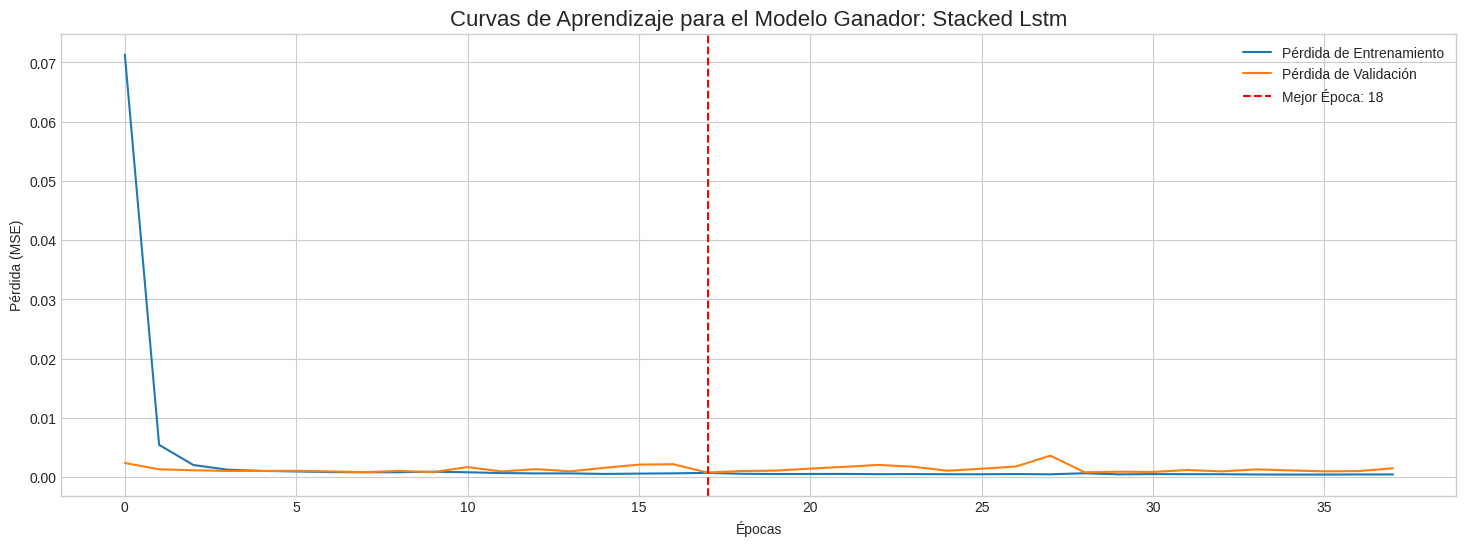

In [146]:
# --- Final Interactive Prediction Plot and Learning Curve ---

# --- Evaluation and Plotting Helper Functions ---
def update_layout(fig, ticker):
    fig.update_layout(
        title=f'Comparación de Valores Reales y Predicciones para {ticker}',
        xaxis_title='Fecha',
        yaxis_title=f'Precio de {ticker}',
        template='plotly_white',
        hovermode='x unified',
        legend=dict(yanchor="top", y=0.99, xanchor="left", x=0.01),
        showlegend=True, margin=dict(l=50, r=50, t=50, b=50)
    )
    fig.update_xaxes(showgrid=True, gridwidth=1, gridcolor='rgba(128,128,128,0.2)')
    fig.update_yaxes(showgrid=True, gridwidth=1, gridcolor='rgba(128,128,128,0.2)')

# --- Final Interactive Prediction Plot ---
full_history_df = pd.DataFrame({'Real': features_df[TARGET_TICKER]}, index=features_df.index)
pred_test_df = pd.DataFrame({'Predicción': lstm_final_preds}, index=dates_test)
cutoff_date = dates_test.min().to_pydatetime()

# Calculate Bollinger Bands for the entire dataset for context
full_history_df['BB_MA'] = full_history_df['Real'].rolling(window=20).mean()
full_history_df['BB_STD'] = full_history_df['Real'].rolling(window=20).std()
full_history_df['BB_UPPER'] = full_history_df['BB_MA'] + (full_history_df['BB_STD'] * 2)
full_history_df['BB_LOWER'] = full_history_df['BB_MA'] - (full_history_df['BB_STD'] * 2)

fig = go.Figure()

# Add Bollinger Bands (confidence bands)
fig.add_trace(go.Scatter(x=full_history_df.index, y=full_history_df['BB_UPPER'], mode='lines', line=dict(color='rgba(173, 216, 230, 0.5)'), name='Banda Superior'))
fig.add_trace(go.Scatter(x=full_history_df.index, y=full_history_df['BB_LOWER'], mode='lines', line=dict(color='rgba(173, 216, 230, 0.5)'), fill='tonexty', fillcolor='rgba(173, 216, 230, 0.2)', name='Banda Inferior'))

# Add real values
fig.add_trace(go.Scatter(x=full_history_df.index, y=full_history_df['Real'], name='Real (IPC)', line=dict(color='black', width=2)))

# Add winning LSTM predictions
fig.add_trace(go.Scatter(x=pred_test_df.index, y=pred_test_df['Predicción'], name=f'Predicción {final_model_name}', line=dict(color='red', width=2, dash='dash')))

# Add ARIMA predictions
fig.add_trace(go.Scatter(x=dates_test, y=arima_preds, name='Predicción ARIMA', line=dict(color='purple', width=2, dash='dot')))

# Add vertical line
fig.add_vline(x=cutoff_date, line_dash="dot", line_color="green")
fig.add_annotation(x=cutoff_date, y=1, yref="paper", text="Inicio de Prueba", showarrow=False, xanchor="left", font=dict(color="green"))

# Update layout
update_layout(fig, TARGET_TICKER)
print("\n--- Gráfica Comparativa de Predicciones en el Conjunto de Prueba ---")
fig.show()

# --- Learning Curve ---
model_type_key = list(training_histories.keys())[0]
history_data = training_histories[model_type_key]

plt.figure(figsize=(18, 6))
plt.plot(history_data['train_loss'], label='Pérdida de Entrenamiento')
plt.plot(history_data['val_loss'], label='Pérdida de Validación')
plt.title(f'Curvas de Aprendizaje para el Modelo Ganador: {model_type_key}', fontsize=16)
plt.xlabel('Épocas')
plt.ylabel('Pérdida (MSE)')
best_epoch = np.argmin(history_data['val_loss'])
plt.axvline(x=best_epoch, color='r', linestyle='--', label=f'Mejor Época: {best_epoch+1}')
plt.legend()
plt.grid(True)
print(f"\n--- Curva de Aprendizaje del Modelo {model_type_key} ---")
plt.show()

In [147]:
# --- Predicción Dinámica, Señales y Gráfico con Bandas de Confianza ---

N_FORECAST_DAYS = 30 # Pronóstico para los próximos 30 días

# Obtener la última secuencia de datos disponible
last_sequence = features_scaled[-WINDOW_SIZE:]
current_sequence_tensor = torch.tensor(last_sequence, dtype=torch.float32).unsqueeze(0).to(device)

future_predictions_scaled = []

final_model.eval()
with torch.no_grad():
    for _ in range(N_FORECAST_DAYS):
        next_pred_scaled = final_model(current_sequence_tensor)
        future_predictions_scaled.append(next_pred_scaled.item())
        
        new_step_features = current_sequence_tensor[0, -1, :].clone()
        new_step_features[0] = next_pred_scaled
        
        new_sequence = torch.cat((current_sequence_tensor[:, 1:, :], new_step_features.unsqueeze(0).unsqueeze(1)), dim=1)
        current_sequence_tensor = new_sequence

# Invertir la transformación de las predicciones futuras
future_predictions_inv = inverse_transform_preds(np.array(future_predictions_scaled), feature_scaler, NUM_FEATURES)

# Crear un índice de fechas futuras
last_date = features_df.index[-1]
future_dates = pd.to_datetime([last_date + pd.DateOffset(days=i) for i in range(1, N_FORECAST_DAYS + 1)])

# --- Generar Señales de Inversión (con horizonte de 15 días añadido) ---
last_actual_price = features_df[TARGET_TICKER].iloc[-1]
# MODIFICACIÓN: Añadir horizonte de 15 días
horizons = {
    'Mañana (1 día)': 1, 
    'Próxima Semana (7 días)': 7, 
    'Próximos 15 días': 15,
    'Próximo Mes (30 días)': N_FORECAST_DAYS
}
recommendations = []

for name, day in horizons.items():
    if day <= len(future_predictions_inv):
        pred_price = future_predictions_inv[day-1]
        signal = "Comprar" if pred_price > last_actual_price else ("Vender" if pred_price < last_actual_price else "Mantener")
        recommendations.append({
            "Horizonte": name,
            "Precio Predicho": f"{pred_price:,.2f}",
            "Cambio Esperado": f"{(pred_price/last_actual_price - 1):.2%}",
            "Señal de Inversión": signal
        })

recommendations_df = pd.DataFrame(recommendations).set_index('Horizonte')
print(f"\n--- Recomendaciones de Inversión basadas en el último precio de {last_actual_price:,.2f} ---")
display(recommendations_df)

# --- Gráfica de Pronóstico Futuro con Bandas de Confianza ---
fig_future = go.Figure()

# Calcular el error estándar de la predicción (usando el RMSE del test set)
prediction_error_std = final_summary.loc[final_model_name, 'RMSE']
confidence_multiplier = 1.96 # Para un intervalo de confianza del 95%

# Calcular bandas superior e inferior
upper_band = future_predictions_inv + (prediction_error_std * confidence_multiplier)
lower_band = future_predictions_inv - (prediction_error_std * confidence_multiplier)

# Añadir Bandas de Confianza
fig_future.add_trace(go.Scatter(
    x=future_dates, y=upper_band, mode='lines', 
    line=dict(color='rgba(255, 0, 0, 0.2)'), name='Banda Superior (95%)'
))
fig_future.add_trace(go.Scatter(
    x=future_dates, y=lower_band, mode='lines',
    line=dict(color='rgba(255, 0, 0, 0.2)'), fill='tonexty', 
    fillcolor='rgba(255, 0, 0, 0.1)', name='Banda Inferior (95%)'
))

# Añadir historial reciente
recent_history = features_df.iloc[-90:]
fig_future.add_trace(go.Scatter(x=recent_history.index, y=recent_history[TARGET_TICKER], name='Historia Reciente', line=dict(color='black', width=2)))

# Añadir pronóstico principal
fig_future.add_trace(go.Scatter(x=future_dates, y=future_predictions_inv, name='Pronóstico LSTM', line=dict(color='red', dash='dash', width=2)))

fig_future.update_layout(
    title=f'Pronóstico del {TARGET_TICKER} para los Próximos {N_FORECAST_DAYS} Días con Intervalo de Confianza',
    xaxis_title='Fecha', yaxis_title=f'Precio de {TARGET_TICKER}',
    template='plotly_white', hovermode='x unified'
)
print("\n--- Gráfica de Pronóstico Futuro ---")
fig_future.show()


--- Recomendaciones de Inversión basadas en el último precio de 56,478.90 ---


,Precio Predicho,Cambio Esperado,Señal de Inversión
Horizonte,,,
Mañana (1 día),"56,526.44",0.08%,Comprar
Próxima Semana (7 días),"57,030.82",0.98%,Comprar
Próximos 15 días,"57,019.64",0.96%,Comprar
Próximo Mes (30 días),"57,019.41",0.96%,Comprar



--- Gráfica de Pronóstico Futuro ---


In [150]:
# --- 9.2. Construir el Panel de Control Unificado (VERSIÓN CONSOLIDADA) ---
print("\n--- Panel de Control Consolidado de Análisis y Pronóstico ---")

# MODIFICACIÓN: Crear 4 subplots en lugar de 5
fig = make_subplots(
    rows=4, cols=1, shared_xaxes=True, vertical_spacing=0.04,
    row_heights=[0.4, 0.15, 0.25, 0.2],  # Alturas ajustadas para dar prioridad a los gráficos principales
    subplot_titles=(
        'Pronóstico Futuro con Bandas de Confianza', 
        'Visualización de la División de Datos', 
        'Indicadores Técnicos (Precio, MAs, B. Bollinger)', 
        'Índice de Fuerza Relativa (RSI)'
    )
)

# --- Gráfico 1: Pronóstico Futuro con Bandas de Confianza (Sin cambios) ---
prediction_error_std = final_summary.loc[final_model_name, 'RMSE']
confidence_multiplier = 1.96 # Para un intervalo de confianza del 95%
upper_band = future_predictions_inv + (prediction_error_std * confidence_multiplier)
lower_band = future_predictions_inv - (prediction_error_std * confidence_multiplier)

recent_history = features_df.iloc[-90:]
fig.add_trace(go.Scatter(x=recent_history.index, y=recent_history[TARGET_TICKER], name='Historia Reciente', line=dict(color='black')), row=1, col=1)
fig.add_trace(go.Scatter(x=future_dates, y=upper_band, mode='lines', line=dict(color='rgba(255,0,0,0.2)'), showlegend=False), row=1, col=1)
fig.add_trace(go.Scatter(x=future_dates, y=lower_band, mode='lines', line=dict(color='rgba(255,0,0,0.2)'), fill='tonexty', fillcolor='rgba(255,0,0,0.1)', name='Banda de Confianza (95%)'), row=1, col=1)
fig.add_trace(go.Scatter(x=future_dates, y=future_predictions_inv, name='Pronóstico LSTM', line=dict(color='red', dash='dash')), row=1, col=1)

# --- Gráfico 2: División de Datos (Sin cambios) ---
fig.add_trace(go.Scatter(x=plot_df.index, y=plot_df[TARGET_TICKER], name='Datos Completos', line=dict(color='lightgray')), row=2, col=1)
fig.add_trace(go.Scatter(x=dates_train, y=plot_df.loc[dates_train, TARGET_TICKER], name='Entrenamiento', line=dict(color='#1f77b4')), row=2, col=1)
fig.add_trace(go.Scatter(x=dates_val, y=plot_df.loc[dates_val, TARGET_TICKER], name='Validación', line=dict(color='#ff7f0e')), row=2, col=1)
fig.add_trace(go.Scatter(x=dates_test, y=plot_df.loc[dates_test, TARGET_TICKER], name='Prueba', line=dict(color='#2ca02c')), row=2, col=1)

# --- Gráfico 3: CONSOLIDADO - Medias Móviles y Bandas de Bollinger ---
# Se grafican en este orden para que las capas se vean correctamente: Relleno -> Líneas -> Precio
# 1. Bandas de Bollinger (área sombreada)
fig.add_trace(go.Scatter(x=plot_df.index, y=plot_df[f'{TARGET_TICKER}_BB_UPPER'], line=dict(color='rgba(0,0,0,0)'), showlegend=False), row=3, col=1)
fig.add_trace(go.Scatter(x=plot_df.index, y=plot_df[f'{TARGET_TICKER}_BB_LOWER'], name='B. Bollinger', line=dict(color='rgba(0,0,0,0)'), fill='tonexty', fillcolor='rgba(173, 216, 230, 0.3)'), row=3, col=1)
# 2. Medias Móviles
fig.add_trace(go.Scatter(x=plot_df.index, y=plot_df[f'{TARGET_TICKER}_SMA'], name='SMA (20)', line=dict(color='blue', dash='dash')), row=3, col=1)
fig.add_trace(go.Scatter(x=plot_df.index, y=plot_df[f'{TARGET_TICKER}_EMA'], name='EMA (20)', line=dict(color='orange', dash='dash')), row=3, col=1)
# 3. Precio (línea sólida encima de todo)
fig.add_trace(go.Scatter(x=plot_df.index, y=plot_df[TARGET_TICKER], name='Precio IPC', line=dict(color='black', width=1), showlegend=False), row=3, col=1)


# --- Gráfico 4: RSI (Ahora en la fila 4) ---
fig.add_trace(go.Scatter(x=plot_df.index, y=plot_df[f'{TARGET_TICKER}_RSI'], name='RSI', line=dict(color='purple')), row=4, col=1)
fig.add_hline(y=70, line_dash="dash", line_color="red", row=4, col=1)
fig.add_hline(y=30, line_dash="dash", line_color="green", row=4, col=1)
fig.add_annotation(x=plot_df.index[30], y=75, text="Sobrecompra", showarrow=False, row=4, col=1)
fig.add_annotation(x=plot_df.index[30], y=25, text="Sobrevendido", showarrow=False, row=4, col=1)

# --- Actualizar Diseño General ---
fig.update_layout(height=1200, template='plotly_white', showlegend=True, hovermode='x unified', title_text=f"<b>Panel de Control para {TARGET_TICKER}</b>")
fig.update_yaxes(title_text="Precio", row=1, col=1)
fig.update_yaxes(title_text="Precio", row=2, col=1)
fig.update_yaxes(title_text="Indicadores", row=3, col=1) # Título del nuevo gráfico consolidado
fig.update_yaxes(title_text="RSI", range=[0, 100], row=4, col=1)
fig.update_xaxes(title_text="Fecha", row=4, col=1)

fig.show()


--- Panel de Control Consolidado de Análisis y Pronóstico ---


### 7. Guardado de Artefactos del Modelo

Para poder utilizar este modelo en el futuro sin necesidad de reentrenarlo, es fundamental guardar los componentes clave:

1.  **El Estado del Modelo (`state_dict`)**: Contiene todos los pesos y sesgos aprendidos por la red neuronal. Es la forma más flexible y recomendada de guardar modelos en PyTorch.
2.  **El Escalador de Características (`feature_scaler`)**: El objeto `MinMaxScaler` que se ajustó a los datos de entrenamiento. Es **crucial** guardarlo, ya que cualquier dato nuevo para predicción debe ser escalado exactamente de la misma manera.
3.  **El Orden de las Columnas**: La lista de las columnas y su orden exacto tal como se usaron para entrenar el modelo. Esto garantiza que los datos futuros se procesen correctamente antes de pasarlos al modelo.
4.  **Los Hiperparámetros**: Se guardan los mejores parámetros encontrados por Optuna para poder reconstruir la arquitectura del modelo sin necesidad de ejecutar la búsqueda de nuevo.

Estos artefactos nos permitirán cargar el modelo y hacer nuevas predicciones de manera consistente.

In [145]:
# --- Create a directory to save the artifacts ---
artifact_dir = 'model_artifacts'
os.makedirs(artifact_dir, exist_ok=True)

# --- 1. Save the final model's state dictionary ---
model_path = os.path.join(artifact_dir, f'{model_type.replace(" ", "_").lower()}_final_model.pth')
torch.save(final_model.state_dict(), model_path)
print(f"Modelo guardado en: {model_path}")

# --- 2. Save the feature scaler ---
scaler_path = os.path.join(artifact_dir, 'feature_scaler.pkl')
joblib.dump(feature_scaler, scaler_path)
print(f"Escalador guardado en: {scaler_path}")

# --- 3. Save the feature column order ---
columns_path = os.path.join(artifact_dir, 'feature_columns.pkl')
with open(columns_path, 'wb') as f:
    pickle.dump(features_df.columns.tolist(), f)
print(f"Orden de columnas guardado en: {columns_path}")

# --- 4. Save the best hyperparameters ---
params_path = os.path.join(artifact_dir, 'best_params.pkl')
final_params_to_save = best_params.copy()
final_params_to_save['lr'] = learning_rate # Add back the learning rate
final_params_to_save['model_type'] = model_type # Add back the model type
with open(params_path, 'wb') as f:
    pickle.dump(final_params_to_save, f)
print(f"Mejores hiperparámetros guardados en: {params_path}")

Modelo guardado en: model_artifacts/stacked_lstm_final_model.pth
Escalador guardado en: model_artifacts/feature_scaler.pkl
Orden de columnas guardado en: model_artifacts/feature_columns.pkl
Mejores hiperparámetros guardados en: model_artifacts/best_params.pkl
